In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, precision_score

from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

import sys
import os
sys.path.append("/zhouxibin/workspaces/mutations")
from utils.rank import rank_strategy_dictionary
from utils.model import model_name_library
from utils.pipeline import read_sequence
from utils.metrics import read_dms_file

In [2]:
# compute random converage
dms_dir = "../data/dms"
sequence_dir = Path(dms_dir) / "fasta"
gt_dir = Path(dms_dir) / "dms"
results_dir = Path(dms_dir) / "results"

In [3]:
# get all sequence names
sequence_names = [g.stem for g in sequence_dir.glob("*.fa")]

100%|██████████| 542/542 [00:09<00:00, 54.70it/s]


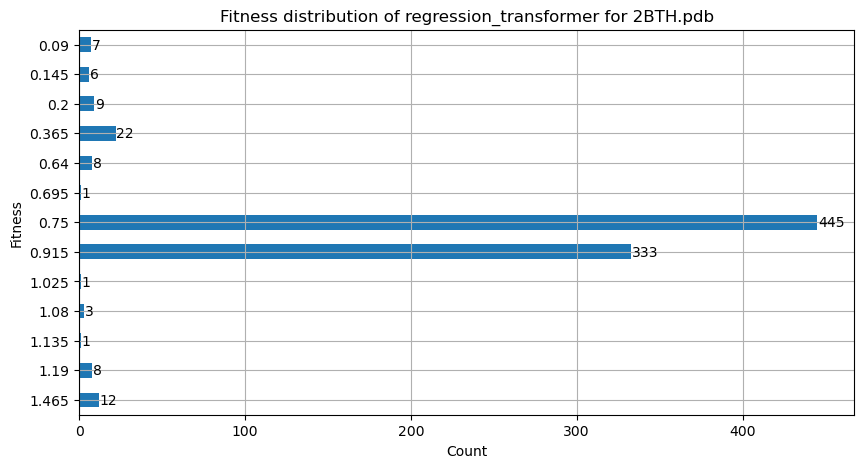

In [6]:
from itertools import product
from tqdm import tqdm
plot_sequence_name = "2BTH.pdb"
results_list = []
for sequence_name in tqdm(sequence_names):
    sequence_file = sequence_dir / (sequence_name + ".fa")
    gt_file = gt_dir / (sequence_name + ".json")
    sequence = read_sequence(sequence_file)
    dms_df = read_dms_file(gt_file, sequence)
    # select wildtype fitness
    wt_fitness = dms_df[dms_df["sequence"] == ("M"+sequence)]["fitness"].values[0]
    count = 0
    for model_name, rank_strategy in product(["regression_transformer", "esm2_t33_650M_UR50D", "esm2_t12_35M_UR50D", "esm2_t12_35M_UR50D_glycosylase"], ["esm1v_1", "esm1v_5"]):
        if rank_strategy == "AR_5":
            continue
        if rank_strategy == "esm1v_1" and model_name != "regression_transformer":
            continue
        result_file = results_dir / (sequence_name + "_" + model_name + "_" + rank_strategy + "_.csv")
        # if not (rank_strategy == "esm1v_5" and model_name == "esm2_t48_15B_UR50D"):
        #     continue
        # print(result_file)
        if result_file.exists():
            try:
                result_df = pd.read_csv(result_file)
            except:
                print(result_file)
                with open(result_file, "r") as f:
                    print(f.read())
                break
            if model_name == "regression_transformer" and sequence_name == plot_sequence_name:
                # show the value
                ax = result_df["fitness"].value_counts().sort_index(ascending=False).plot(
                    kind="barh", 
                    grid=True,
                    title=f"Fitness distribution of {model_name} for {sequence_name}",
                    ylabel="Fitness",
                    xlabel="Count",
                    figsize=(10, 5),
                    rot=0,
                )
                for i, v in enumerate(result_df["fitness"].value_counts().sort_index(ascending=False).values):  
                    # print(v)
                    ax.text(v + 0.5, i - 0.15, str(v), color='black', fontweight='light')
                plt.savefig(f"./9_data/rt_predict_many_identical_value_{sequence_name}.png", dpi=300)
                plt.savefig(f"./9_data/rt_predict_many_identical_value_{sequence_name}.tiff", dpi=300)
    #         continue
    # break

# results_auc_df = pd.DataFrame(results_list, columns=["sequence_name", "model_name", "rank_strategy", "fpr", "tpr", "threshold", "auc_score", "wt_fitness"])
# results_auc_df.head()